In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats


In [211]:
responses_file = "survey_responses_annon.csv"
df_resps = pd.read_csv(responses_file)

In [212]:
df_resps.info()
df_resps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   chat_gender    588 non-null    object
 1   resp_gender    588 non-null    object
 2   resp_age       585 non-null    object
 3   chat_voiced    539 non-null    object
 4   chat_usage     587 non-null    object
 5   ai_perception  585 non-null    object
 6   resp_language  578 non-null    object
dtypes: object(7)
memory usage: 32.3+ KB


,chat_gender,resp_gender,resp_age,chat_voiced,chat_usage,ai_perception,resp_language
0,Neutral / No gender,Male,21-30,"No, only in a text box",Daily,Strongly Positive,Slovak
1,Definitely Male,Female,15-20,NaN,Weekly,Slightly Positive,English
2,Probably Female,Male,15-20,"No, only in a text box",Weekly,Slightly Positive,English
3,Neutral / No gender,Male,41-60,"No, only in a text box",Less than once a month,Slightly Positive,French
4,Definitely Female,Male,NaN,"No, only in a text box",Less than once a month,Neutral,English


In [213]:
collums = df_resps.columns.tolist()

# for each colum, print all the options
for col in collums:
    print(col)
    print(df_resps[col].unique())

chat_gender
['Neutral / No gender' 'Definitely Male' 'Probably Female'
 'Definitely Female' 'Probably Male' 'Leaning Male' 'Leaning Female']
resp_gender
['Male' 'Female' 'Non-binary/Other' 'Prefer not to say']
resp_age
['21-30' '15-20' '41-60' nan '31-40' '>60' '<15']
chat_voiced
['No, only in a text box' nan 'Yes, with a female voice'
 'Yes, with a male voice']
chat_usage
['Daily' 'Weekly' 'Less than once a month' 'Never' 'Monthly' nan]
ai_perception
['Strongly Positive' 'Slightly Positive' 'Neutral' 'Negative' 'Positive'
 'Slightly Negative' 'Strongly Negative' nan]
resp_language
['Slovak' 'English' 'French' 'Bengali' 'German' 'Polish' nan 'Mandarin'
 'Greek' 'Croatian' 'Danish' 'Algerian' 'Hungarian' 'estonian' 'Khmer'
 'Estonian' 'Italian' 'Spanish' 'Swedish ' 'Dutch' 'Cornish' 'Hebrew'
 'Norwegian' 'Hindi' 'Russian' 'German ' 'Russian ' 'Portuguese '
 'Swedish' 'Bulgarian' 'Romanian' 'English ' 'Filipino' 'Lithuanian'
 'Thai' 'Czech' 'Portuguese']


In [214]:
# Get all the category counts
collums = df_resps.columns.tolist()
for col in collums:
    print(col)
    print(df_resps[col].value_counts())
    print()

chat_gender
chat_gender
Neutral / No gender    245
Leaning Male            95
Probably Male           71
Definitely Male         69
Leaning Female          47
Probably Female         33
Definitely Female       28
Name: count, dtype: int64

resp_gender
resp_gender
Male                 341
Female               212
Non-binary/Other      28
Prefer not to say      7
Name: count, dtype: int64

resp_age
resp_age
15-20    239
21-30    152
31-40     92
41-60     85
>60       11
<15        6
Name: count, dtype: int64

chat_voiced
chat_voiced
No, only in a text box      444
Yes, with a female voice     57
Yes, with a male voice       38
Name: count, dtype: int64

chat_usage
chat_usage
Weekly                    181
Daily                     180
Monthly                   107
Less than once a month     94
Never                      25
Name: count, dtype: int64

ai_perception
ai_perception
Positive             207
Strongly Positive    133
Slightly Positive    112
Neutral               55
Slightly Neg

In [215]:
# Generae some proxy data for gender and conviction of gender perception
simple_gender_mapping = {
    "Leaning Male": "Male",
    "Probably Male": "Male",
    "Definitely Male": "Male",
    "Leaning Female": "Female",
    "Probably Female": "Female",
    "Definitely Female": "Female",
    "Neutral / No gender": "Neutral",
}

df_resps["chat_agg_gender"] = df_resps["chat_gender"].map(simple_gender_mapping)

conviction_gender_mapping = {
    "Leaning Male": "Leaning",
    "Probably Male": "Probably",
    "Definitely Male": "Definitely",
    "Leaning Female": "Leaning",
    "Probably Female": "Probably",
    "Definitely Female": "Definitely",
    "Neutral / No gender": "Neutral",
}

df_resps["chat_conviction_gender"] = df_resps["chat_gender"].map(conviction_gender_mapping)

ai_perception_mapping = {
    "Positive": "Positive",
    "Strongly Positive": "Positive",
    "Slightly Positive": "Positive",
    "Neutral": "Neutral",
    "Slightly Negative": "Negative",
    "Negative": "Negative",
    "Strongly Negative": "Negative",
}

df_resps["ai_agg_perception"] = df_resps["ai_perception"].map(ai_perception_mapping)

df_resps["resp_gender_nbo"] = df_resps["resp_gender"].apply(lambda x: 'Yes' if x == 'Non-binary/Other' else 'No')

In [216]:
# Add aditional cut datasets
df_without_neutrals = df_resps[df_resps["chat_gender"] != "Neutral / No gender"]
df_not_voiced = df_resps[df_resps["chat_voiced"] == "No, only in a text box"]
df_answered_voiced = df_resps[df_resps["chat_voiced"] != pd.NA]
df_answered_voiced.shape

(588, 11)

In [217]:
def calcStdDevBinary(reading, n):
    return math.sqrt(reading * (1 - reading) / n)

def calucluate95error(reading, n):
    return calcStdDevBinary(reading,n) * 1.96

def zTestSame(s1,t1,s2,t2):
    """s is the success, t is the trials"""
    # Calculate proportions
    p1 = s1 / t1
    p2 = s2 / t2

    # Calculate pooled proportion
    p_pooled = (s1 + s2) / (t1 + t2)

    # Calculate standard error
    SE = ((p_pooled * (1 - p_pooled)) * ((1 / t1) + (1 / t2))) ** 0.5

    # Calculate Z-score
    Z = (p1 - p2) / SE

    # Calculate two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(Z)))
    
    return p_value

def chiTestDiff(s1,t1,s2,t2):
    _, p, _, _ = stats.chi2_contingency([[s1,t1-s1],[s2,t2-s2]])
    return p

        
print(chiTestDiff(74,104,111,168)) # :(
print(zTestSame(74,104,111,168))

print(chiTestDiff(0,104,111,168))
print(zTestSame(111,168,111,168))


0.4595545364242152
0.38248078111615946
1.7908340728563308e-26
1.0


{'Neutral / No gender': 245, 'Definitely Male': 69, 'Probably Female': 33, 'Definitely Female': 28, 'Probably Male': 71, 'Leaning Male': 95, 'Leaning Female': 47}


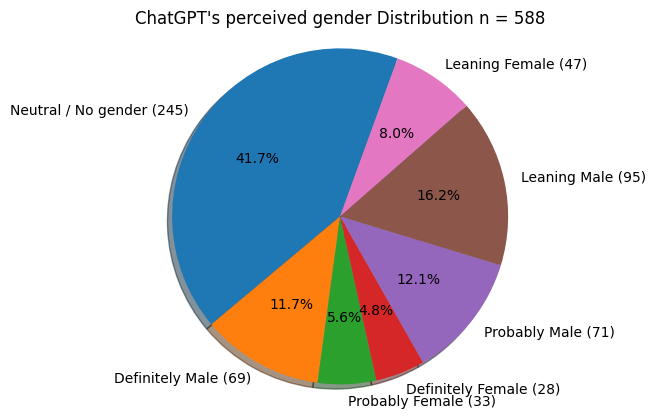

{'Male': 341, 'Female': 212, 'Non-binary/Other': 28, 'Prefer not to say': 7}


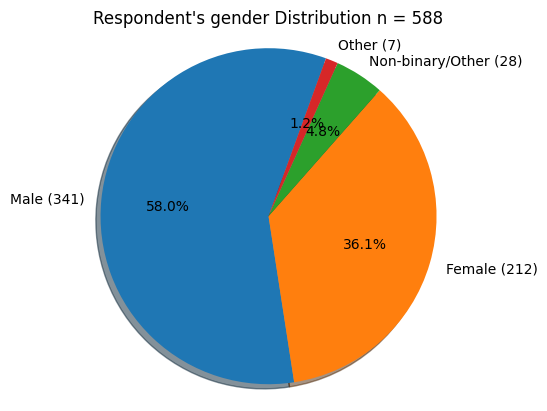

{'21-30': 152, '15-20': 239, '41-60': 85, '31-40': 92, '>60': 11, '<15': 6}


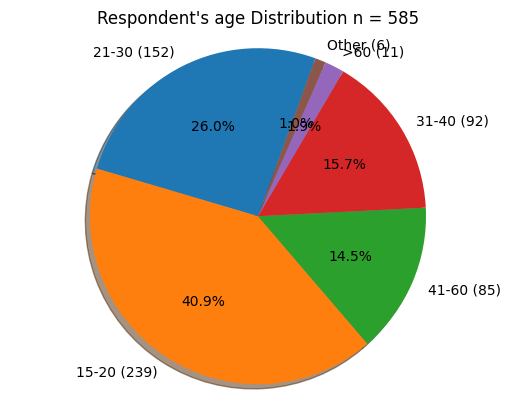

{'No, only in a text box': 444, 'Yes, with a female voice': 57, 'Yes, with a male voice': 38}


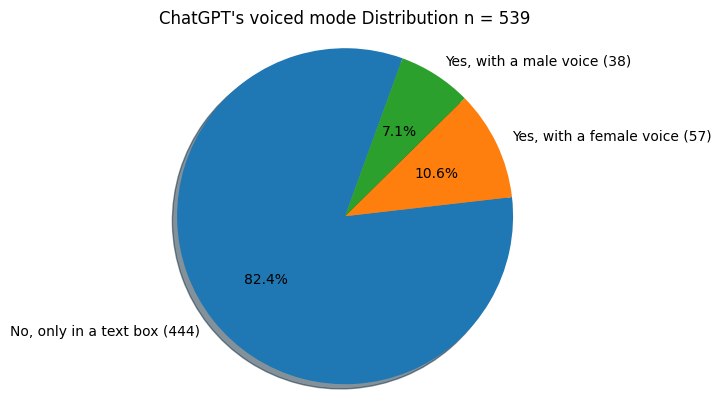

{'Daily': 180, 'Weekly': 181, 'Less than once a month': 94, 'Never': 25, 'Monthly': 107}


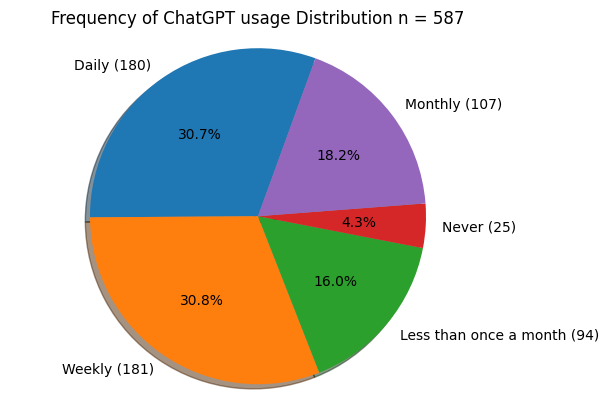

{'Strongly Positive': 133, 'Slightly Positive': 112, 'Neutral': 55, 'Negative': 17, 'Positive': 207, 'Slightly Negative': 47, 'Strongly Negative': 14}


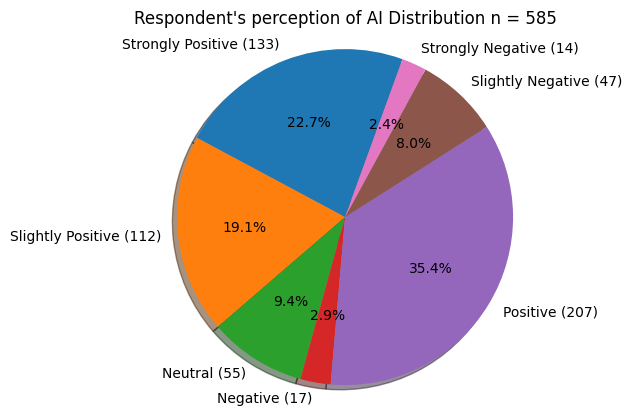

{'Slovak': 1, 'English': 441, 'French': 35, 'Bengali': 1, 'German': 22, 'Polish': 6, 'Mandarin': 8, 'Greek': 3, 'Croatian': 3, 'Danish': 6, 'Algerian': 1, 'Hungarian': 5, 'estonian': 1, 'Khmer': 1, 'Estonian': 3, 'Italian': 1, 'Spanish': 10, 'Swedish ': 1, 'Dutch': 2, 'Cornish': 1, 'Hebrew': 1, 'Norwegian': 2, 'Hindi': 5, 'Russian': 2, 'German ': 1, 'Russian ': 2, 'Portuguese ': 2, 'Swedish': 2, 'Bulgarian': 1, 'Romanian': 1, 'English ': 1, 'Filipino': 1, 'Lithuanian': 1, 'Thai': 2, 'Czech': 1, 'Portuguese': 1}


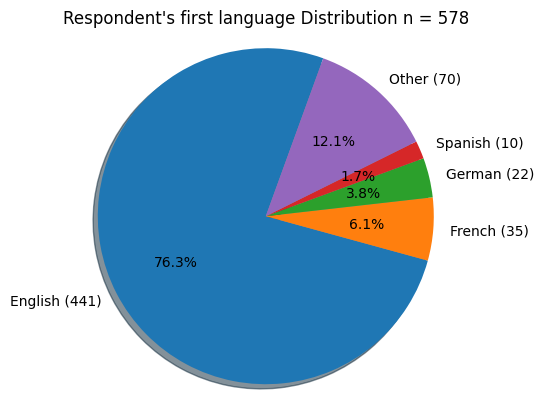

{'Neutral': 245, 'Male': 235, 'Female': 108}


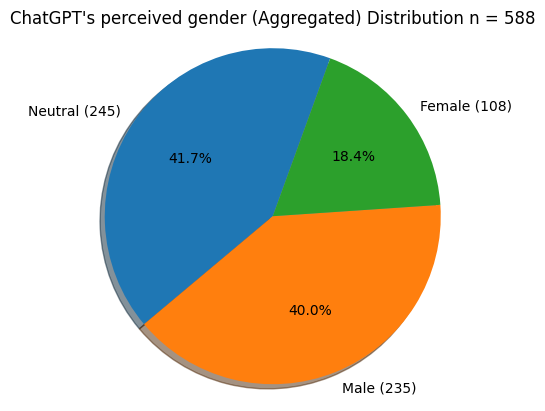

{'Neutral': 245, 'Definitely': 97, 'Probably': 104, 'Leaning': 142}


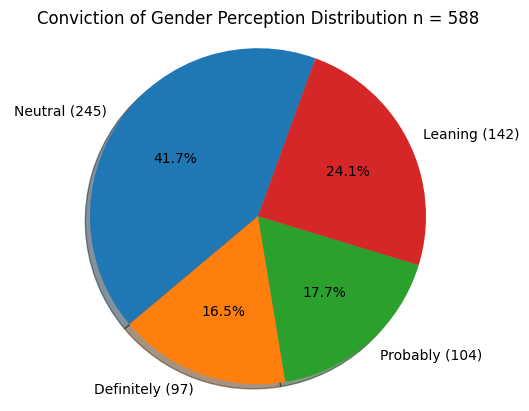

{'Positive': 452, 'Neutral': 55, 'Negative': 78}


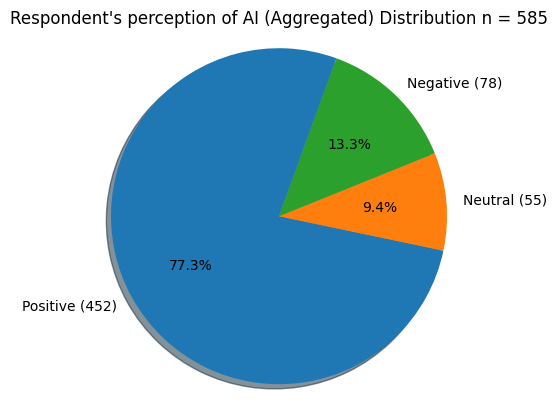

{'No': 560, 'Yes': 28}


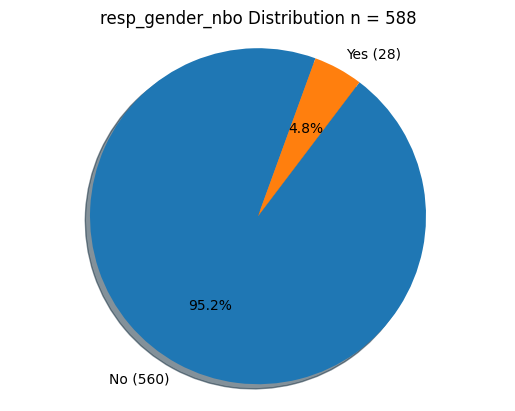

{'Neutral / No gender': 189, 'Probably Female': 24, 'Definitely Female': 19, 'Probably Male': 59, 'Leaning Male': 72, 'Leaning Female': 35, 'Definitely Male': 46}


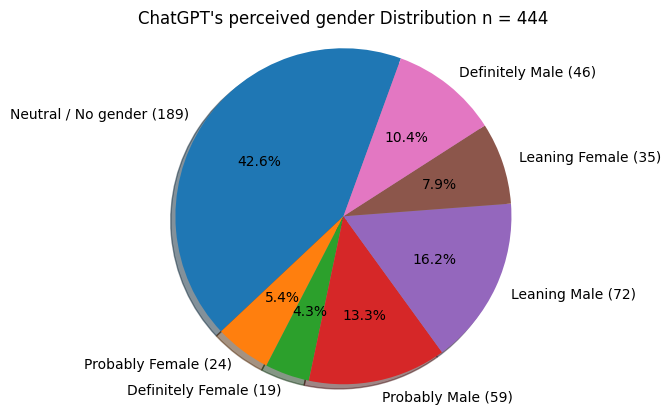

{'Male': 240, 'Female': 182, 'Non-binary/Other': 17, 'Prefer not to say': 5}


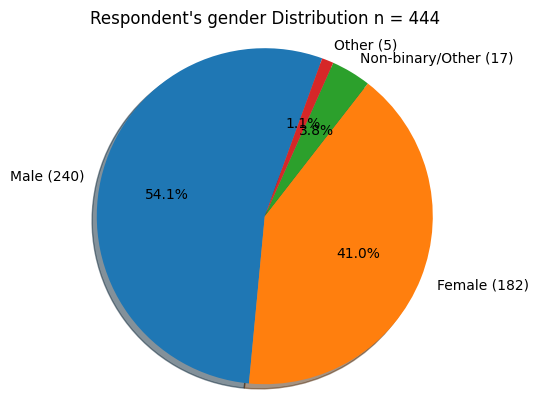

{'21-30': 107, '15-20': 197, '41-60': 67, '31-40': 60, '>60': 7, '<15': 4}


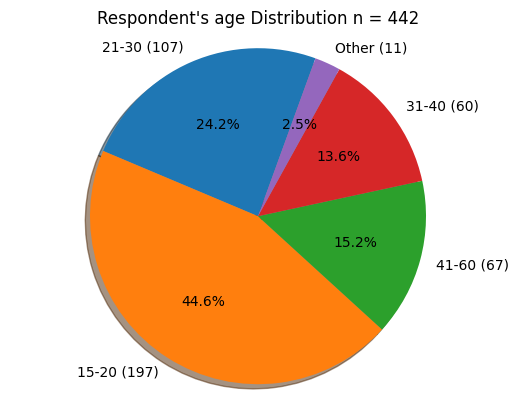

{'No, only in a text box': 444}


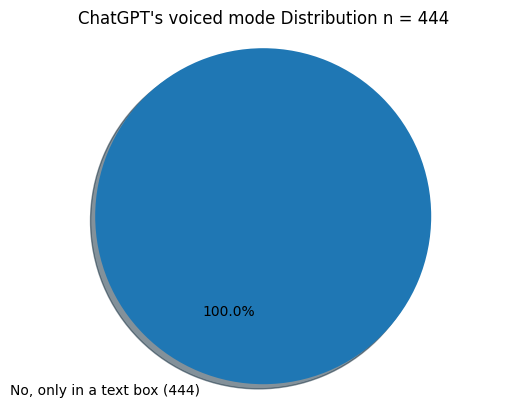

{'Daily': 106, 'Weekly': 146, 'Less than once a month': 80, 'Never': 18, 'Monthly': 94}


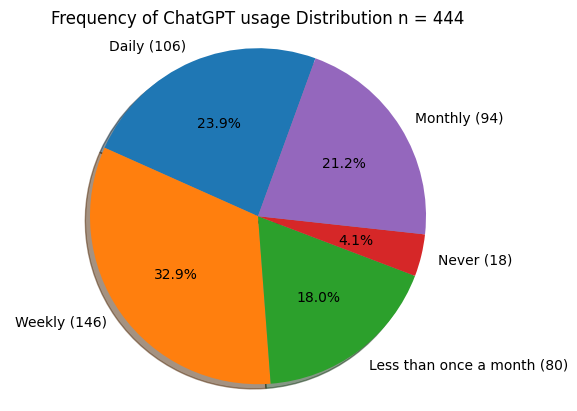

{'Strongly Positive': 84, 'Slightly Positive': 98, 'Neutral': 46, 'Negative': 11, 'Positive': 158, 'Slightly Negative': 34, 'Strongly Negative': 12}


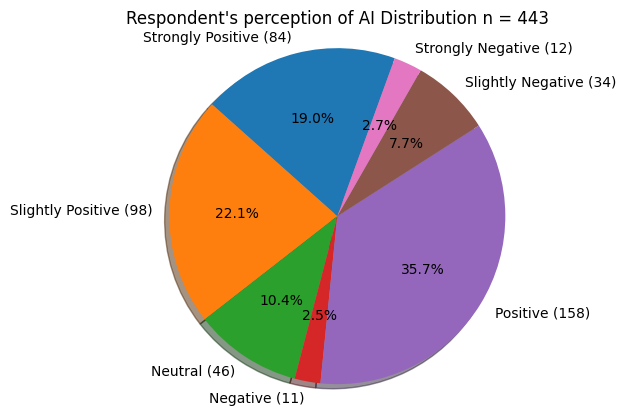

{'Slovak': 1, 'English': 343, 'French': 22, 'Bengali': 1, 'German': 12, 'Polish': 6, 'Mandarin': 7, 'Greek': 1, 'Croatian': 2, 'Danish': 3, 'Hungarian': 4, 'estonian': 1, 'Khmer': 1, 'Estonian': 2, 'Italian': 1, 'Spanish': 7, 'Cornish': 1, 'Hebrew': 1, 'Hindi': 3, 'Norwegian': 1, 'German ': 1, 'Russian ': 2, 'Swedish': 1, 'Russian': 1, 'Bulgarian': 1, 'Romanian': 1, 'English ': 1, 'Filipino': 1, 'Lithuanian': 1, 'Thai': 2, 'Portuguese ': 1, 'Czech': 1, 'Dutch': 1, 'Portuguese': 1}


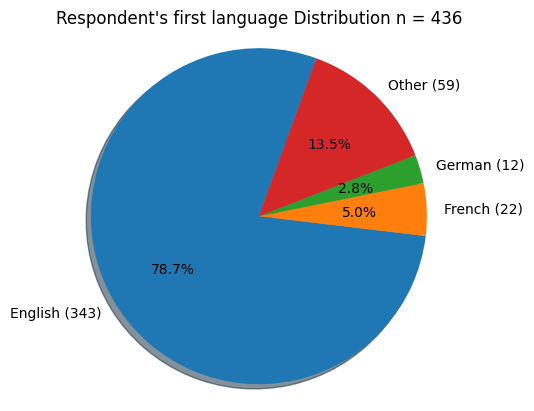

{'Neutral': 189, 'Female': 78, 'Male': 177}


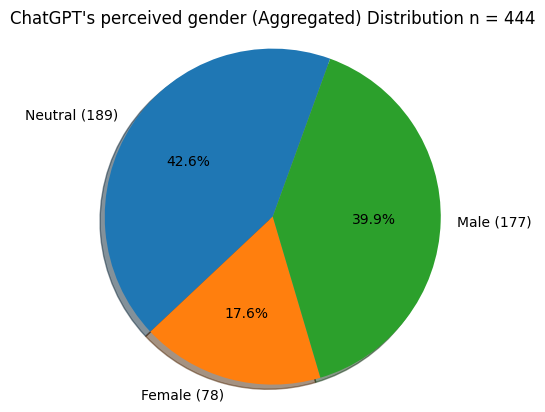

{'Neutral': 189, 'Probably': 83, 'Definitely': 65, 'Leaning': 107}


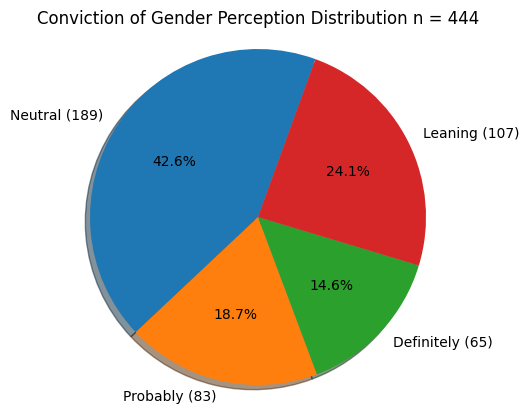

{'Positive': 340, 'Neutral': 46, 'Negative': 57}


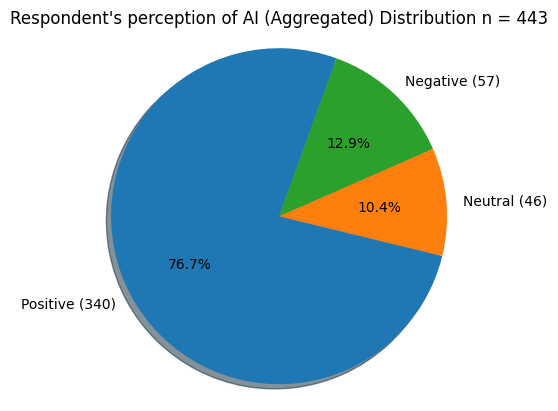

{'No': 427, 'Yes': 17}


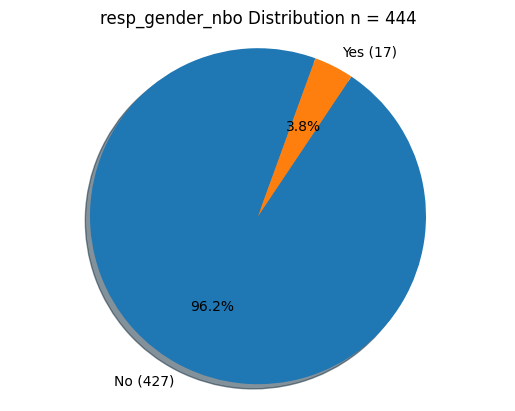

In [218]:
col_name_to_display_name = {
    "chat_gender": "ChatGPT's perceived gender",
    "chat_voiced": "ChatGPT's voiced mode",
    "resp_gender": "Respondent's gender",
    "resp_age": "Respondent's age",
    "chat_usage": "Frequency of ChatGPT usage",
    "ai_perception": "Respondent's perception of AI",
    "resp_language": "Respondent's first language",
    "ai_agg_perception": "Respondent's perception of AI (Aggregated)",
    "chat_agg_gender": "ChatGPT's perceived gender (Aggregated)",
    "chat_conviction_gender": "Conviction of Gender Perception",
}

def generate_pie_chart(df,feild):
    # Get the counts for each option
    feild_options = df[feild].tolist()
    option_counts = {}
    for option in feild_options:
        if str(option) != "nan":
            option_counts[option] = df[df[feild] == option].shape[0]
        
    total = sum(option_counts.values())
    print(option_counts)

    # for all options with less than 10, remove them and add them to the "other" category
    other_count = 0
    keys_to_read = list(option_counts.keys())
    for option in keys_to_read:
        if option_counts[option] < 10:
            other_count += option_counts[option]
            del option_counts[option]

    if other_count != 0:
        option_counts["Other"] = other_count

    # labels = [f"{option} ({option_counts[option]}) ±{calucluate95error(option_counts[option]/total,total)*100:0.2f}%" for option in option_counts.keys()]
    labels = [f"{option} ({option_counts[option]})" for option in option_counts.keys()]

    # Generate the pie chart
    plt.title(f"{col_name_to_display_name.get(feild,feild)} Distribution n = {total}")
    plt.pie(option_counts.values(), labels=labels, autopct='%1.1f%%', shadow=True, startangle=70)
    plt.axis('equal')
    plt.show()

for feild in df_resps.columns:
    generate_pie_chart(df_resps,feild)

for feild in df_not_voiced.columns:
    generate_pie_chart(df_not_voiced,feild)

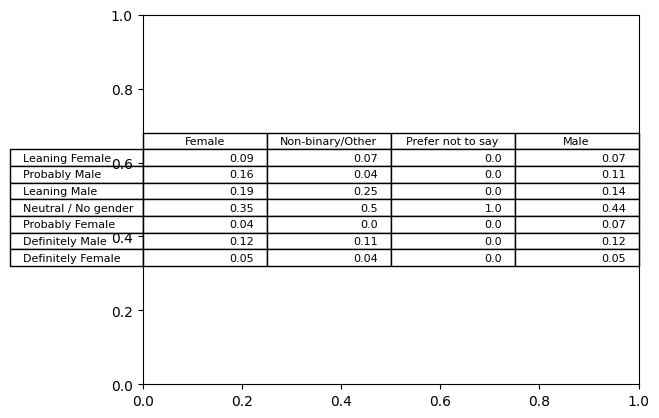

In [219]:
# Generate pivot tables for correlations between two
def generate_pivot_table(feild1, feild2): # put the percentage of the total in the table, % of feild2 that are feild1
    feild1_options = list(set(df_resps[feild1].tolist()))
    feild2_options = list(set(df_resps[feild2].tolist()))
    # print(feild1_options, feild2_options)
    matrix = np.zeros((len(feild1_options), len(feild2_options)))
    for i1, option1 in enumerate(feild1_options):
        for i2, option2 in enumerate(feild2_options):
            matrix[i1][i2] = round((df_resps[(df_resps[feild1] == option1) & (df_resps[feild2] == option2)].shape[0]) / df_resps[df_resps[feild2] == option2].shape[0], 2)

    plt.table(cellText=matrix, rowLabels=feild1_options, colLabels=feild2_options, loc='center')

generate_pivot_table("chat_gender","resp_gender")


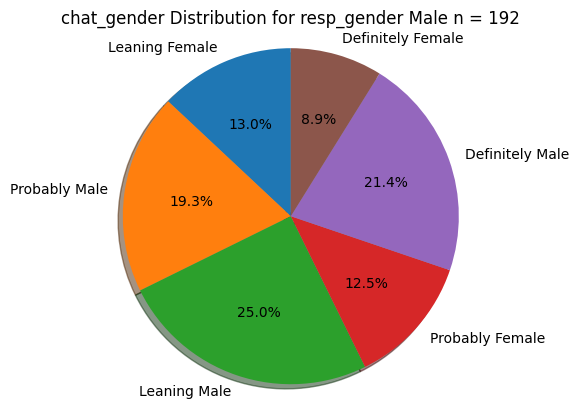

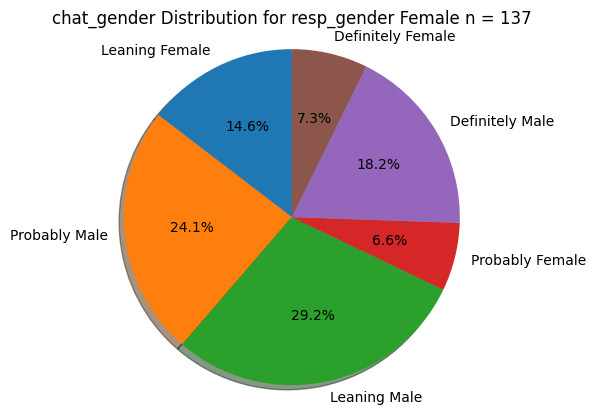

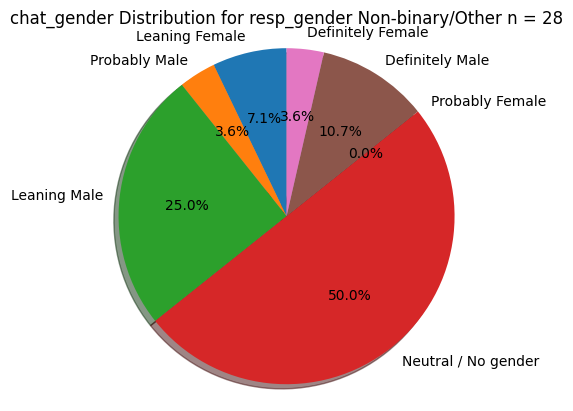

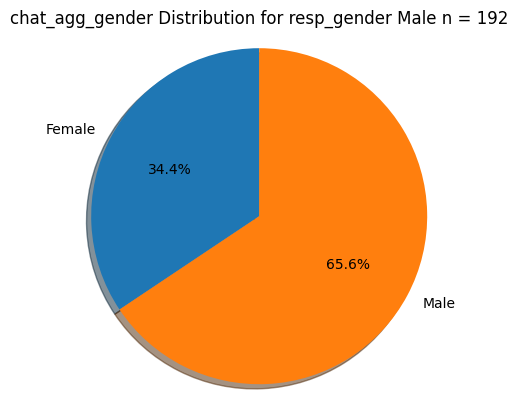

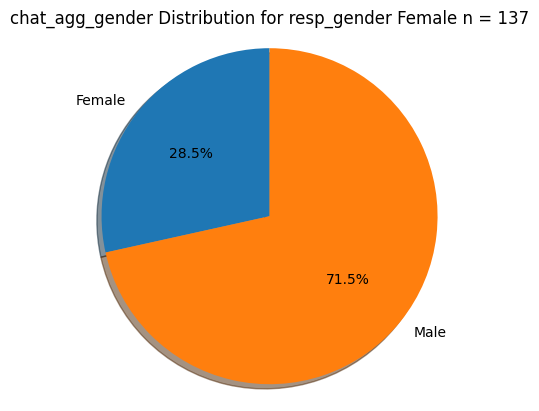

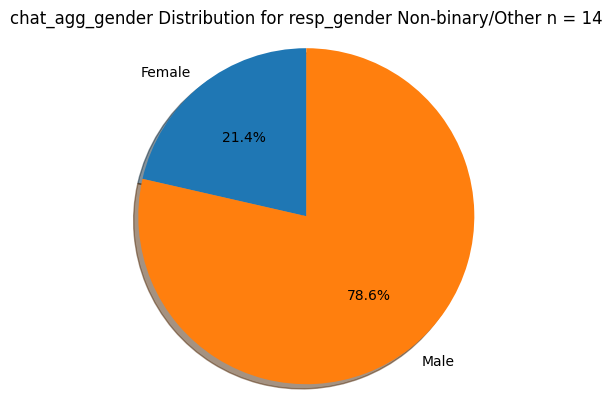

In [220]:
# generate a pie chart of feild1 for a given option of feild2
def generate_pie_chart_for_option(df,feild1, feild2, option2):
    feild1_options = list(set(df[feild1].tolist()))
    option_counts = {}
    for option in feild1_options:
        option_counts[option] = df[(df[feild1] == option) & (df[feild2] == option2)].shape[0]
        
    # Generate the pie chart
    plt.title(f"{feild1} Distribution for {feild2} {option2} n = {sum(option_counts.values())}")
    try:
        plt.pie(option_counts.values(), labels=option_counts.keys(), autopct='%1.1f%%', shadow=True, startangle=90)
    except:
        pass
    plt.axis('equal')
    plt.show()


generate_pie_chart_for_option(df_without_neutrals,"chat_gender","resp_gender","Male")
generate_pie_chart_for_option(df_without_neutrals,"chat_gender","resp_gender","Female")
generate_pie_chart_for_option(df_resps,"chat_gender","resp_gender","Non-binary/Other")
generate_pie_chart_for_option(df_without_neutrals,"chat_agg_gender","resp_gender","Male")
generate_pie_chart_for_option(df_without_neutrals,"chat_agg_gender","resp_gender","Female")
generate_pie_chart_for_option(df_without_neutrals,"chat_agg_gender","resp_gender","Non-binary/Other")

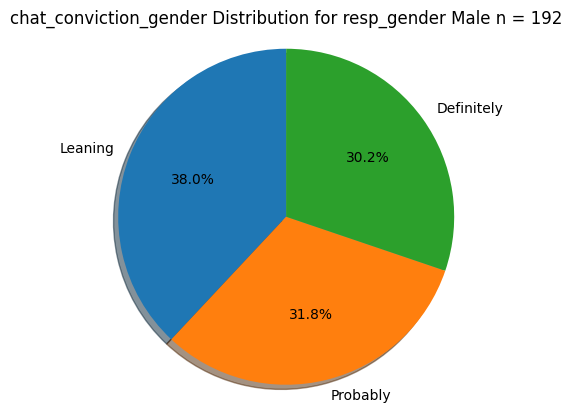

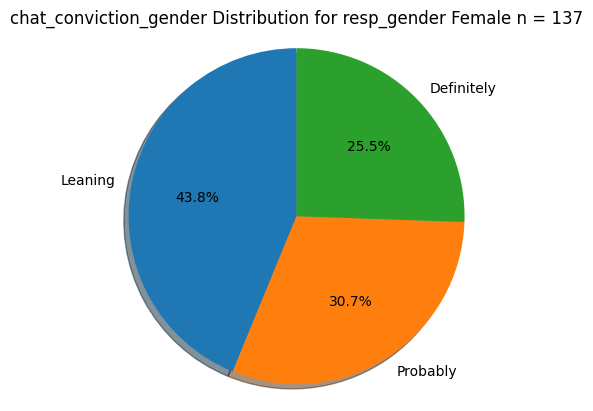

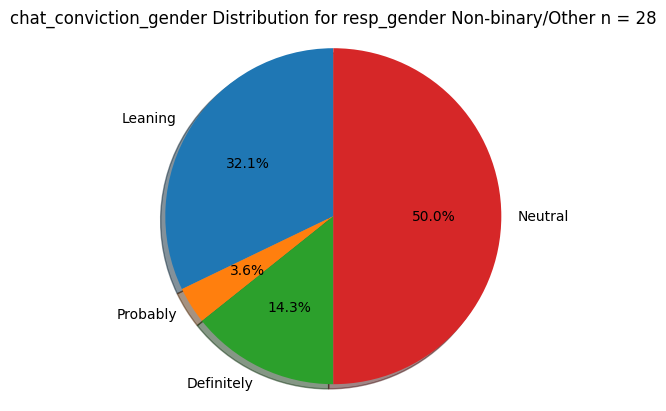

In [221]:
generate_pie_chart_for_option(df_without_neutrals,"chat_conviction_gender","resp_gender","Male")
generate_pie_chart_for_option(df_without_neutrals,"chat_conviction_gender","resp_gender","Female")
generate_pie_chart_for_option(df_resps,"chat_conviction_gender","resp_gender","Non-binary/Other")


<15


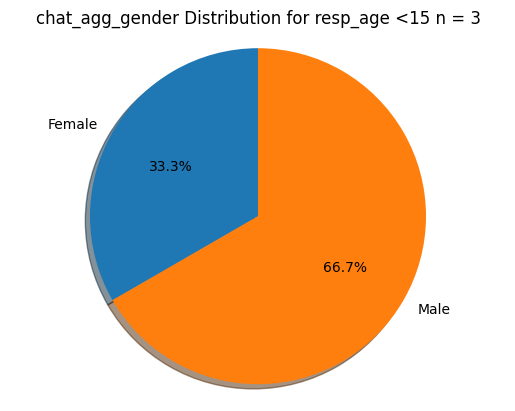

15-20


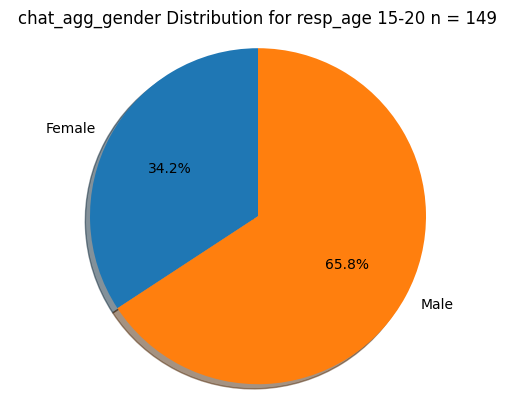

21-30


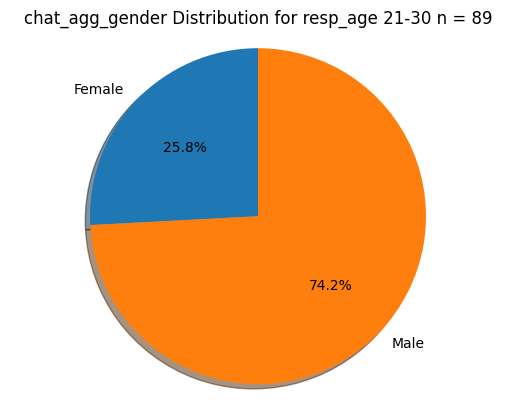

41-60


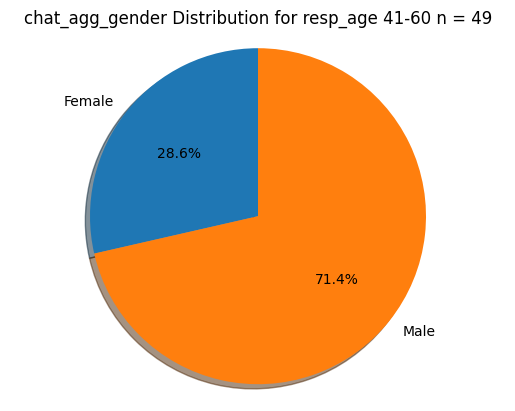

31-40


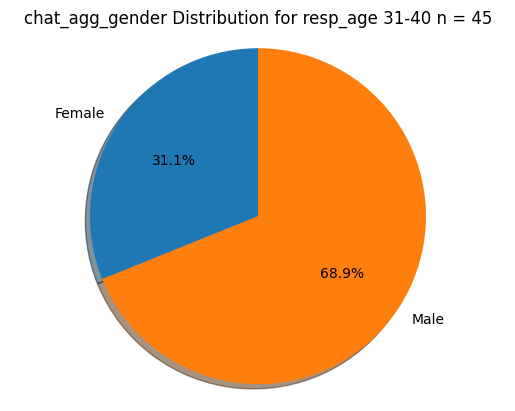

>60


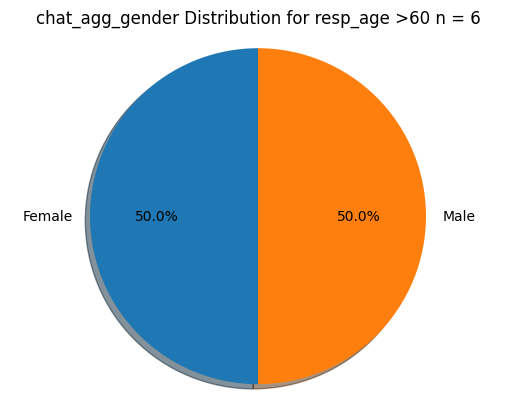

In [222]:
# Generate pie charts for feild1 on all options of feild2
def generate_pie_chart_for_all_options(df,feild1, feild2):
    feild2_options = list(set(df[feild2].tolist()))
    for option2 in feild2_options:
        try:
            if type(option2) == str:
                print(option2)
                generate_pie_chart_for_option(df,feild1, feild2, option2)
        except:
            pass

df_without_neutrals_has_age = df_without_neutrals[df_without_neutrals["resp_age"] != None]

try:
    generate_pie_chart_for_all_options(df_without_neutrals_has_age,"chat_agg_gender","resp_age")
except:
    pass

Slightly Negative


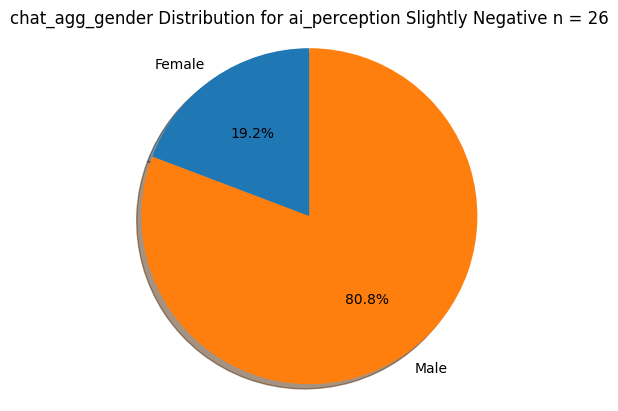

Negative


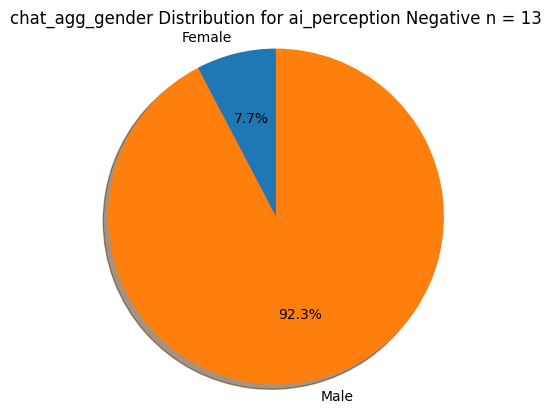

Strongly Positive


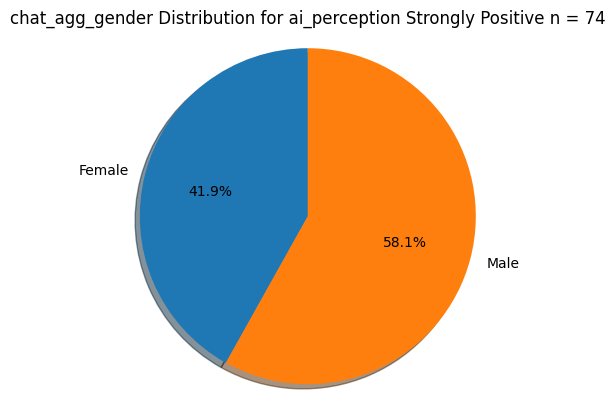

Positive


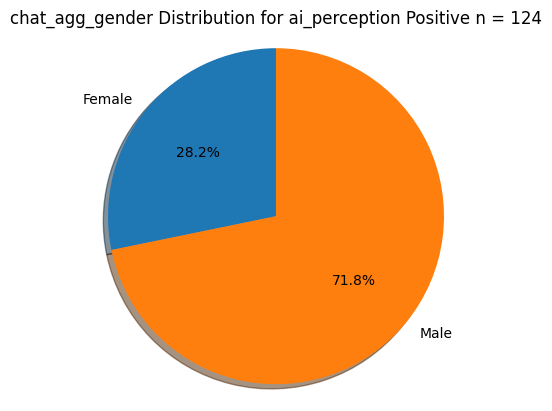

Strongly Negative


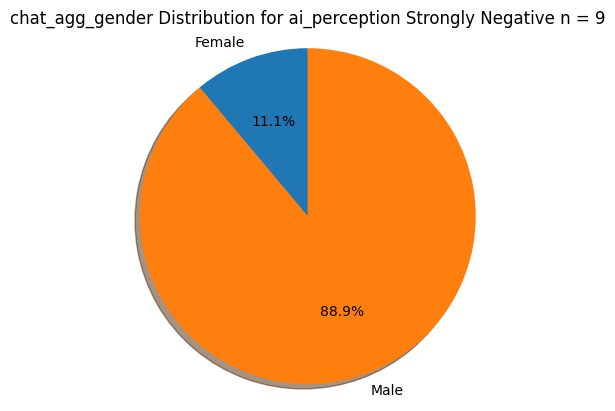

Slightly Positive


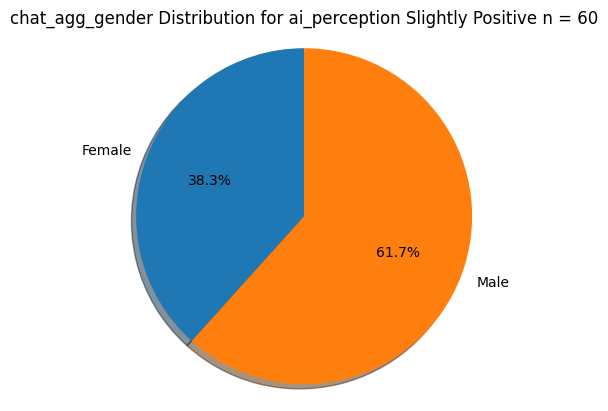

Neutral


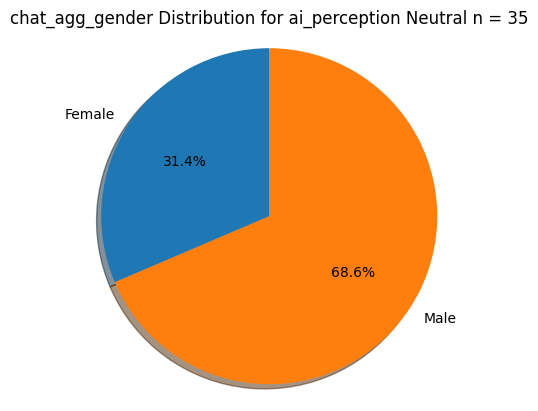

In [223]:
generate_pie_chart_for_all_options(df_without_neutrals_has_age,"chat_agg_gender","ai_perception")

(255, 11)
(22, 11)
(34, 11)
[[0.31 0.   0.65]
 [0.69 1.   0.35]]
[0.056766402656749655, 0.0, 0.16032723888788133]
[0.05676640265674966, 0.0, 0.16032723888788133]


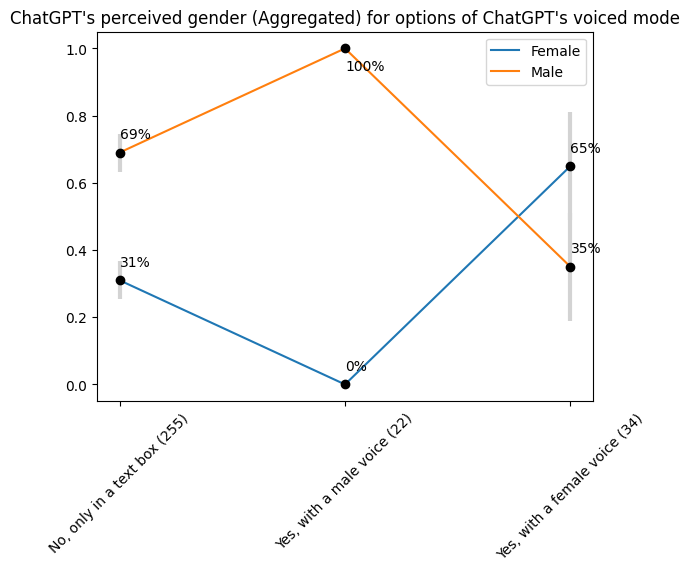

(137, 11)
(192, 11)
(14, 11)
[[0.28 0.34 0.21]
 [0.72 0.66 0.79]]
[0.0751867048349747, 0.06700649222276897, 0.21336110235935696]
[0.0751867048349747, 0.06700649222276897, 0.21336110235935696]


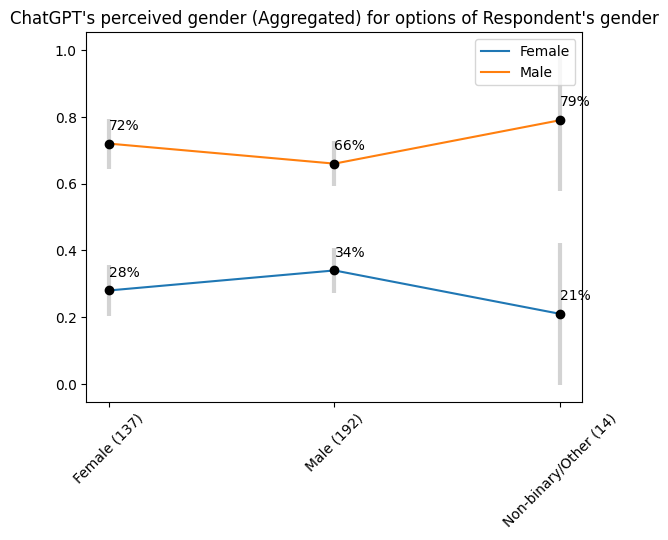

(212, 11)
(341, 11)
(28, 11)
[[0.18 0.19 0.11]
 [0.46 0.37 0.39]
 [0.35 0.44 0.5 ]]
[0.051716761269692976, 0.041638798735281764, 0.11589598785117627]
[0.0670909492532198, 0.05124482550231256, 0.18066510454429213]
[0.0642064770729029, 0.05268648599452817, 0.18520259177452134]


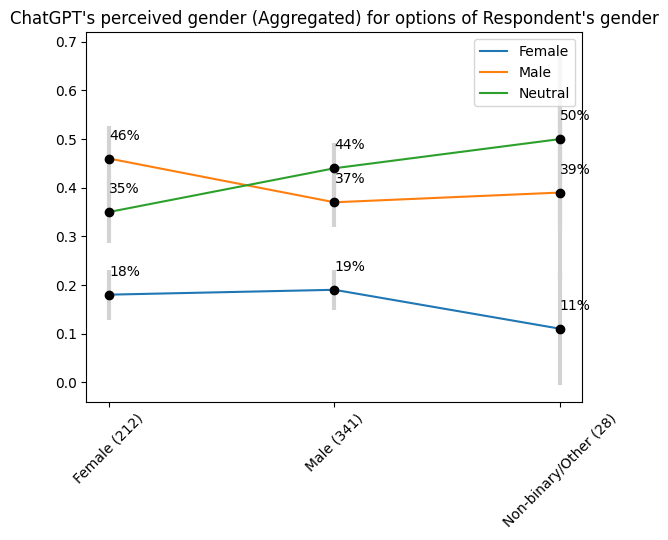

(3, 11)
(149, 11)
(89, 11)
(45, 11)
(49, 11)
(6, 11)
[[0.33 0.34 0.26 0.31 0.29 0.5 ]
 [0.67 0.66 0.74 0.69 0.71 0.5 ]]
[0.5320957808515304, 0.07606315990873645, 0.09113046827044735, 0.13513106723967414, 0.12705337461083038, 0.40008332465458574]
[0.5320957808515304, 0.07606315990873645, 0.09113046827044735, 0.13513106723967414, 0.12705337461083038, 0.40008332465458574]


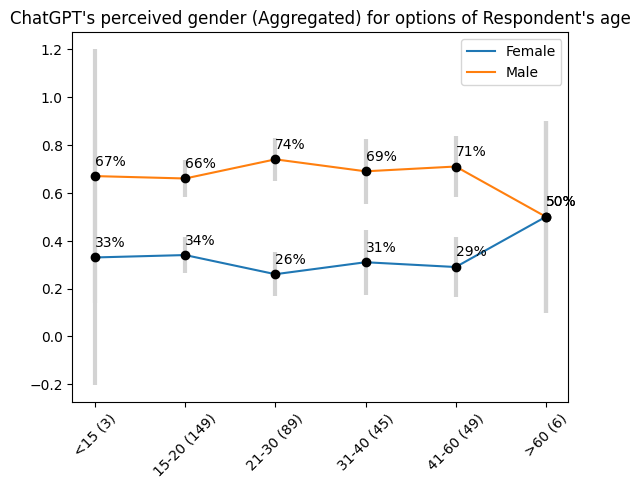

(6, 11)
(239, 11)
(152, 11)
(92, 11)
(85, 11)
(11, 11)
[[0.17 0.29 0.24 0.17 0.22 0.09]
 [0.   0.19 0.2  0.11 0.18 0.27]
 [0.33 0.15 0.15 0.21 0.18 0.18]
 [0.5  0.38 0.41 0.51 0.42 0.45]]
[0.3005688384824126, 0.05752879722765157, 0.06789639165669999, 0.07675835601021758, 0.08806538747197014, 0.16912261286362087]
[0.0, 0.049736638625437105, 0.06359079708325892, 0.06393718384681069, 0.08167512113100724, 0.2623632734830226]
[0.37624853488086835, 0.045270179161771736, 0.05676614076051062, 0.08323104562915054, 0.08167512113100724, 0.22704027676323704]
[0.40008332465458574, 0.06153819645903642, 0.0781901797576033, 0.102151626431539, 0.10492651546229305, 0.29400000000000004]


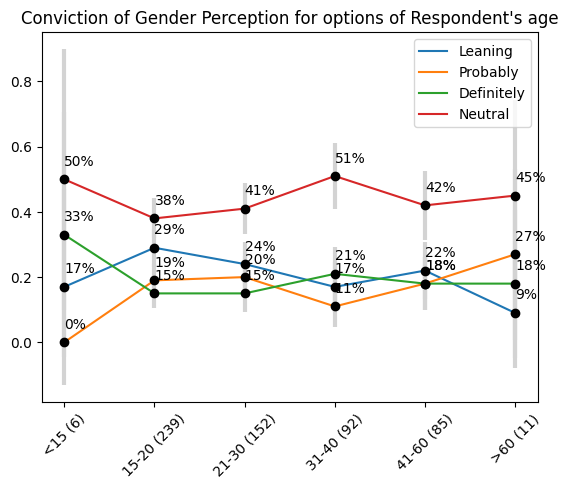

(74, 11)
(124, 11)
(60, 11)
(35, 11)
(26, 11)
(13, 11)
(9, 11)
[[0.42 0.28 0.38 0.31 0.19 0.08 0.11]
 [0.58 0.72 0.62 0.69 0.81 0.92 0.89]]
[0.11245502163928425, 0.07902972899179224, 0.12281971611539683, 0.15322422784925363, 0.15079561307636546, 0.14747666308215057, 0.20442130786958368]
[0.11245502163928425, 0.07902972899179224, 0.12281971611539683, 0.15322422784925363, 0.15079561307636544, 0.14747666308215054, 0.20442130786958368]


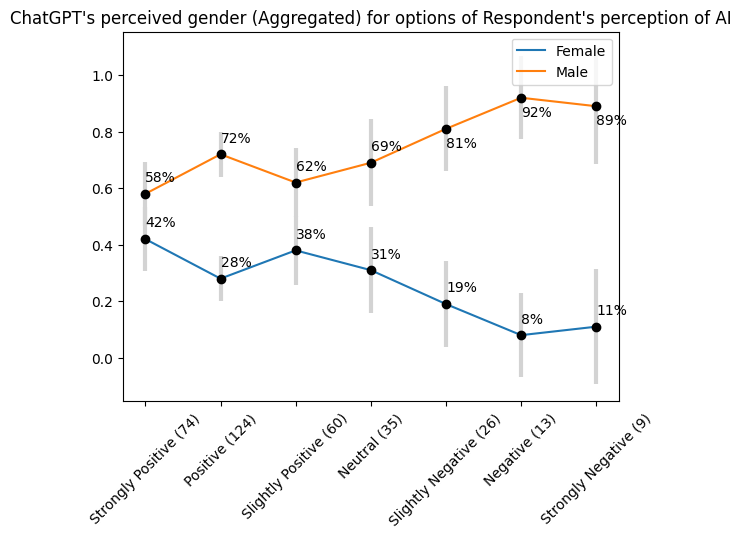

(133, 11)
(207, 11)
(112, 11)
(55, 11)
(47, 11)
(17, 11)
(14, 11)
[[0.17 0.26 0.26 0.27 0.3  0.29 0.14]
 [0.16 0.2  0.14 0.18 0.13 0.18 0.36]
 [0.23 0.14 0.13 0.18 0.13 0.29 0.14]
 [0.44 0.4  0.46 0.36 0.45 0.24 0.36]]
[0.06384012927041391, 0.059754887415577225, 0.08123619882786245, 0.11733242286148128, 0.13101372349750562, 0.21570478736949172, 0.1817629225117158]
[0.062306002076339656, 0.05449176687358221, 0.0642628975381596, 0.10153549849459279, 0.09614759929953441, 0.1826311229194617, 0.2514393763912089]
[0.07152198042707239, 0.047269841065907287, 0.06228426767651684, 0.10153549849459279, 0.09614759929953441, 0.21570478736949172, 0.1817629225117158]
[0.08436272561791856, 0.0667385120114859, 0.09230449609851084, 0.12685744612108363, 0.14223115737298764, 0.20302243283759094, 0.2514393763912089]


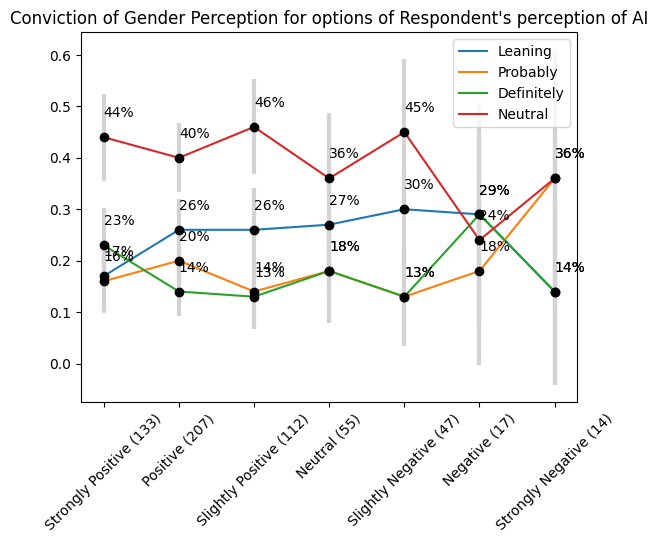

(109, 11)
(105, 11)
(58, 11)
(56, 11)
(15, 11)
[[0.39 0.31 0.22 0.3  0.13]
 [0.61 0.69 0.78 0.7  0.87]]
[0.0915672230127966, 0.08846404919513914, 0.1066106807096705, 0.12002499739637572, 0.17019301983336452]
[0.0915672230127966, 0.08846404919513914, 0.1066106807096705, 0.12002499739637573, 0.17019301983336452]


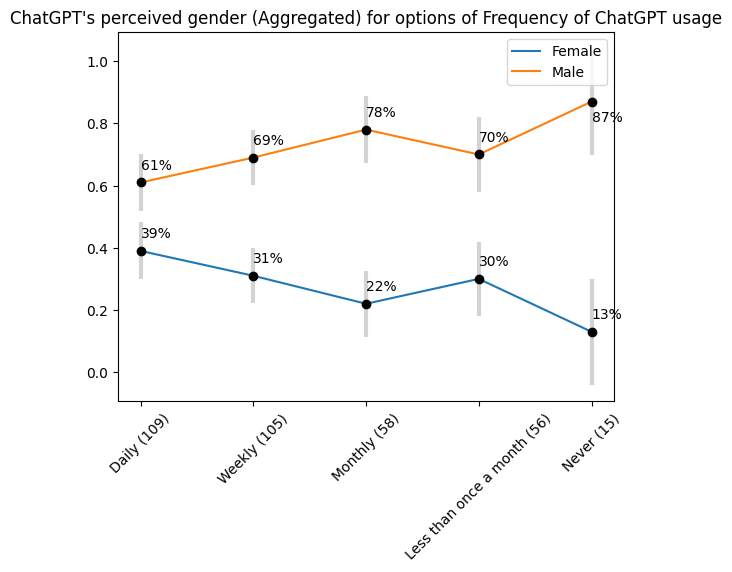

(180, 11)
(181, 11)
(107, 11)
(94, 11)
(25, 11)
[[0.19 0.26 0.25 0.29 0.24]
 [0.18 0.17 0.19 0.18 0.16]
 [0.23 0.15 0.1  0.13 0.2 ]
 [0.39 0.42 0.46 0.4  0.4 ]]
[0.05731115074747671, 0.06390271611654566, 0.0820473991113343, 0.09173188498774161, 0.16741658699185097]
[0.05612585856804331, 0.054724309545654555, 0.07433331349621852, 0.07766678415965302, 0.14370957379381513]
[0.06147932624513346, 0.0520201830784342, 0.056844105555885024, 0.06798661945950772, 0.1568]
[0.07125527816707102, 0.07190439324516827, 0.0944365207353497, 0.09903706591742262, 0.19203999583420114]


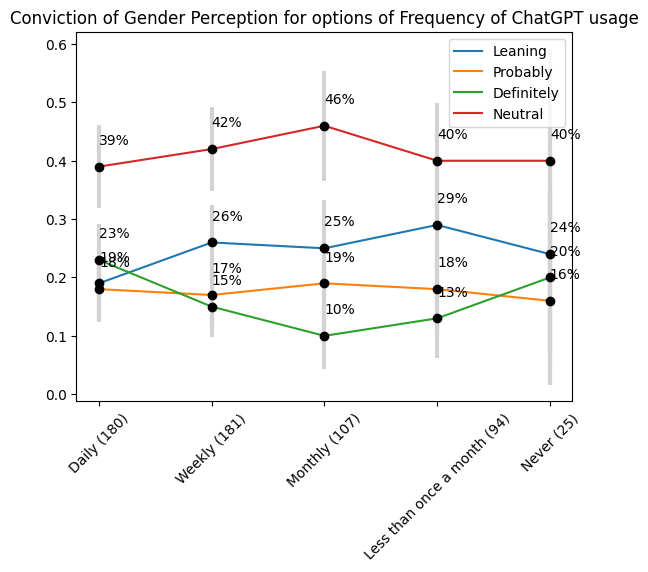

In [224]:
# Plot the curves of feild1 for options of feild2 with a given order on feild2
def generate_curve_for_options(df,feild1, feild2, option_order):
    feild1_options = list(set(df[feild1].tolist()))
    matrix = np.zeros((len(feild1_options), len(option_order)))
    outOptions = []
    option_totals = []
    for i2, option2 in enumerate(option_order):
        for i1, option1 in enumerate(feild1_options):
            if i2 == 0:
                outOptions.append(option1)
            
            matrix[i1][i2] = round((df[(df[feild1] == option1) & (df[feild2] == option2)].shape[0]) / df[df[feild2] == option2].shape[0], 2)

    for i2, option2 in enumerate(option_order):
        # get the number of people in each option
        print(df[df[feild2] == option2].shape)
        option_totals.append(df[df[feild2] == option2].shape[0])

    print(matrix)
    plt.title(f"{col_name_to_display_name.get(feild1,feild1)} for options of {col_name_to_display_name.get(feild2,feild2)}")
    for i in range(len(matrix)):
        plt.plot(matrix[i], label=outOptions[i])
        # label the plot points with the percentage
        for j in range(len(matrix[i])):
            y = matrix[i][j]
            if y > 0.8:
                y -= 0.075
            else:
                y += 0.033
            plt.text(j, y, f"{matrix[i][j]*100:0.0f}%", ha='left', va='bottom')
        # add error bars
        yerrs = [calucluate95error(matrix[i][j], option_totals[j]) for j in range(len(matrix[i]))]
        print(yerrs)
        plt.errorbar(range(len(matrix[i])), matrix[i], yerr=yerrs, fmt='o',color='black',ecolor='lightgray',elinewidth=3,capsize=0)
    # set x-axis tick labels
    tick_labels = [f"{option} ({option_totals[i]})" for i, option in enumerate(option_order)]
    plt.xticks(range(len(option_order)), tick_labels)
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

generate_curve_for_options(df_resps,"chat_agg_gender","chat_voiced",["No, only in a text box", 'Yes, with a male voice','Yes, with a female voice'])
generate_curve_for_options(df_without_neutrals_has_age,"chat_agg_gender","resp_gender",["Female","Male","Non-binary/Other"])
generate_curve_for_options(df_resps,"chat_agg_gender","resp_gender",["Female","Male","Non-binary/Other"])
generate_curve_for_options(df_without_neutrals_has_age,"chat_agg_gender","resp_age",["<15","15-20","21-30","31-40","41-60",">60"])
generate_curve_for_options(df_resps,"chat_conviction_gender","resp_age",["<15","15-20","21-30","31-40","41-60",">60"])
generate_curve_for_options(df_without_neutrals_has_age,"chat_agg_gender","ai_perception",["Strongly Positive","Positive","Slightly Positive","Neutral","Slightly Negative","Negative","Strongly Negative"])
generate_curve_for_options(df_resps,"chat_conviction_gender","ai_perception",["Strongly Positive","Positive","Slightly Positive","Neutral","Slightly Negative","Negative","Strongly Negative"])
generate_curve_for_options(df_without_neutrals_has_age,"chat_agg_gender","chat_usage",['Daily', 'Weekly', 'Monthly', 'Less than once a month','Never'])
generate_curve_for_options(df_resps,"chat_conviction_gender","chat_usage",['Daily', 'Weekly', 'Monthly', 'Less than once a month','Never'])

(258, 11)
(35, 11)
(48, 11)
[[0.34 0.31 0.15]
 [0.66 0.69 0.85]]
[0.057803967032126466, 0.15322422784925363, 0.10101608782763269]
[0.057803967032126466, 0.15322422784925363, 0.10101608782763269]


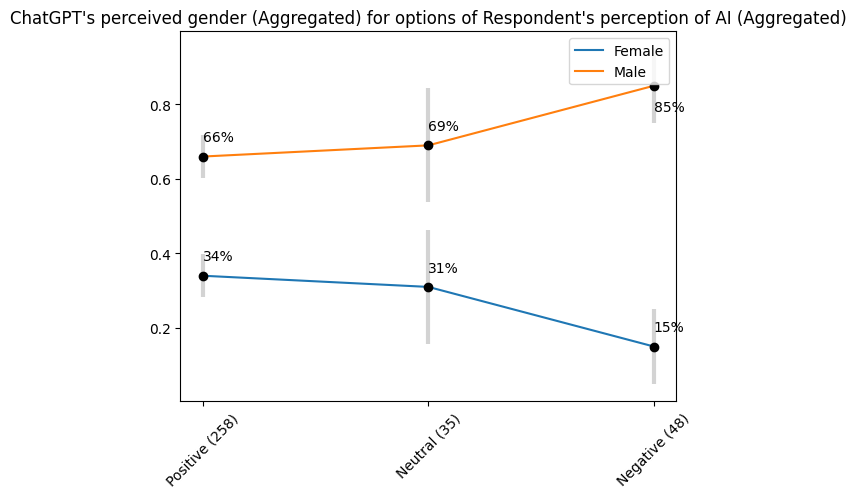

(452, 11)
(55, 11)
(78, 11)
[[0.23 0.27 0.27]
 [0.17 0.18 0.18]
 [0.16 0.18 0.17]
 [0.43 0.36 0.38]]
[0.03879682041529026, 0.11733242286148128, 0.0985262791965052]
[0.03462983009983391, 0.10153549849459279, 0.08526129972484135]
[0.03379764876358861, 0.10153549849459279, 0.08336279684269175]
[0.04564135293070456, 0.12685744612108363, 0.10772001694802155]


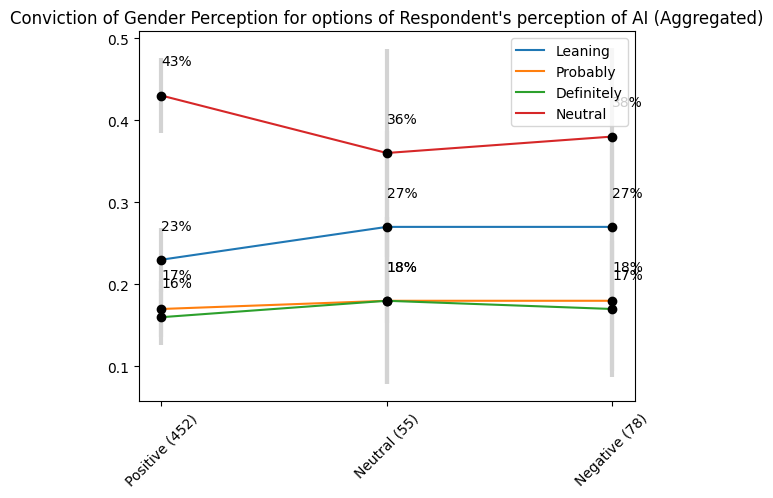

In [233]:
generate_curve_for_options(df_without_neutrals,"chat_agg_gender","ai_agg_perception",["Positive","Neutral","Negative"])
generate_curve_for_options(df_resps,"chat_conviction_gender","ai_agg_perception",["Positive","Neutral","Negative"]) # ; ;

(109, 11)
(105, 11)
(58, 11)
(56, 11)
(15, 11)
[[0.39 0.31 0.22 0.3  0.13]
 [0.61 0.69 0.78 0.7  0.87]]
[0.0915672230127966, 0.08846404919513914, 0.1066106807096705, 0.12002499739637572, 0.17019301983336452]
[0.0915672230127966, 0.08846404919513914, 0.1066106807096705, 0.12002499739637573, 0.17019301983336452]


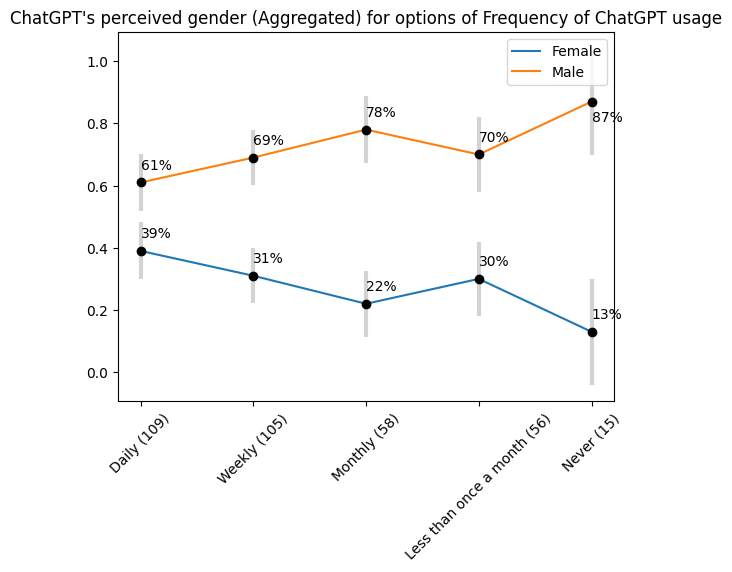

In [226]:
generate_curve_for_options(df_without_neutrals_has_age,"chat_agg_gender","chat_usage",['Daily', 'Weekly', 'Monthly', 'Less than once a month', 'Never'])

(444, 11)
(38, 11)
(57, 11)
[[0.18 0.   0.39]
 [0.4  0.58 0.21]
 [0.43 0.42 0.4 ]]
[0.035736150218405344, 0.0, 0.1266239521700294]
[0.04556907438757716, 0.15692889439085728, 0.10574061610723119]
[0.04605070061385632, 0.15692889439085728, 0.12718159416651784]


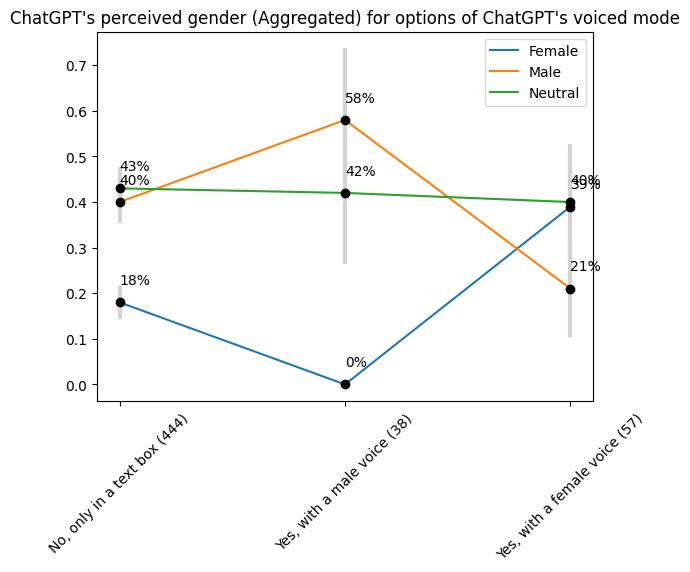

(212, 11)
(341, 11)
(28, 11)
[[0.18 0.19 0.11]
 [0.46 0.37 0.39]
 [0.35 0.44 0.5 ]]
[0.051716761269692976, 0.041638798735281764, 0.11589598785117627]
[0.0670909492532198, 0.05124482550231256, 0.18066510454429213]
[0.0642064770729029, 0.05268648599452817, 0.18520259177452134]


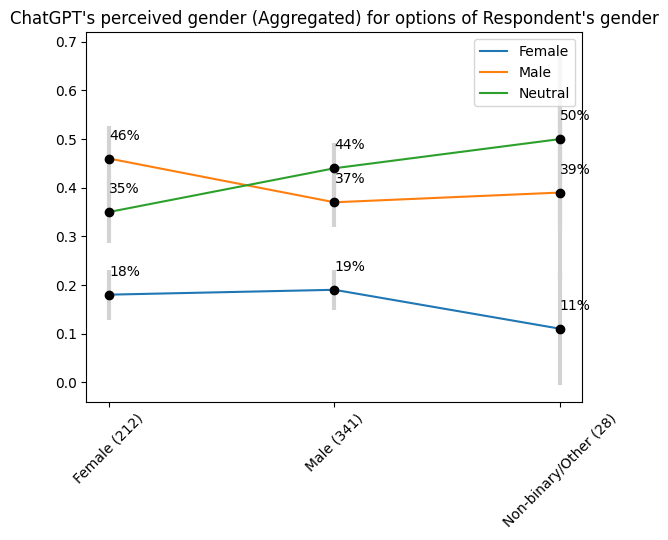

(6, 11)
(239, 11)
(152, 11)
(92, 11)
(85, 11)
(11, 11)
[[0.17 0.21 0.15 0.15 0.16 0.27]
 [0.33 0.41 0.43 0.34 0.41 0.27]
 [0.5  0.38 0.41 0.51 0.42 0.45]]
[0.3005688384824126, 0.051639296119967495, 0.05676614076051062, 0.07296544745109929, 0.07793745909004067, 0.2623632734830226]
[0.37624853488086835, 0.062355541505830545, 0.07870565418062415, 0.09679960474227604, 0.10455975156368164, 0.2623632734830226]
[0.40008332465458574, 0.06153819645903642, 0.0781901797576033, 0.102151626431539, 0.10492651546229305, 0.29400000000000004]


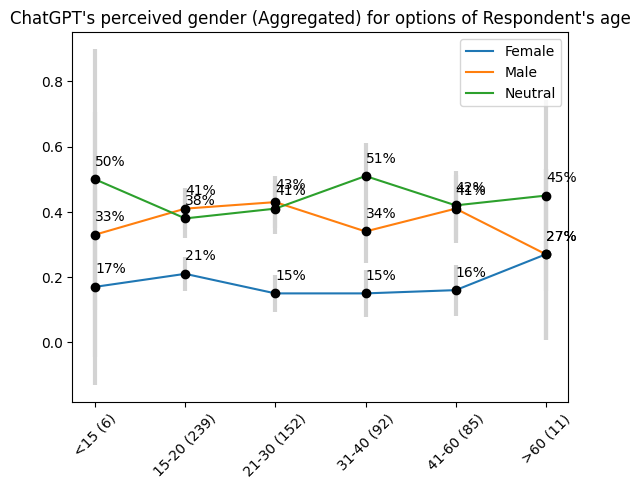

(133, 11)
(207, 11)
(112, 11)
(55, 11)
(47, 11)
(17, 11)
(14, 11)
[[0.23 0.17 0.21 0.2  0.11 0.06 0.07]
 [0.32 0.43 0.33 0.44 0.45 0.71 0.57]
 [0.44 0.4  0.46 0.36 0.45 0.24 0.36]]
[0.07152198042707239, 0.05117223734014505, 0.0754345411598692, 0.10571453843423638, 0.08945373700315593, 0.11289407841501904, 0.1336541806304614]
[0.07927927983102719, 0.06744388112682481, 0.08708461402567046, 0.13118829216054306, 0.14223115737298764, 0.21570478736949175, 0.25933653811216034]
[0.08436272561791856, 0.0667385120114859, 0.09230449609851084, 0.12685744612108363, 0.14223115737298764, 0.20302243283759094, 0.2514393763912089]


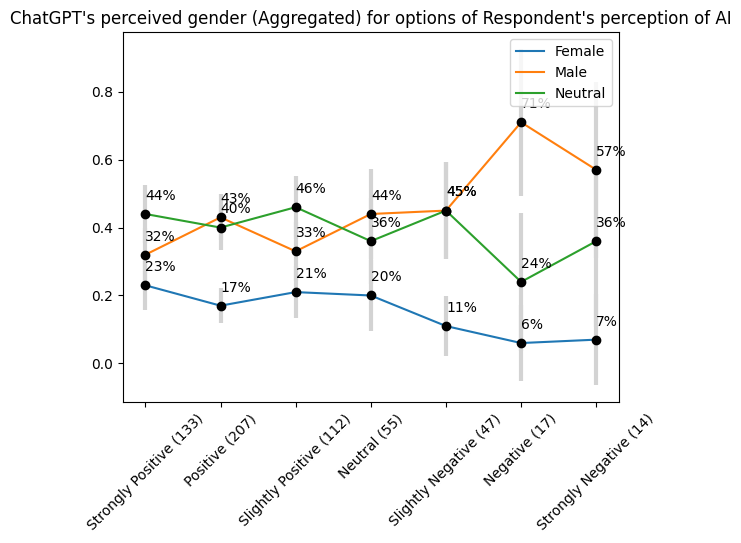

(180, 11)
(181, 11)
(107, 11)
(94, 11)
(25, 11)
[[0.24 0.18 0.12 0.18 0.08]
 [0.37 0.4  0.42 0.41 0.52]
 [0.39 0.42 0.46 0.4  0.4 ]]
[0.06239247817913096, 0.05597060001731572, 0.06157382621509204, 0.07766678415965302, 0.1063469341354042]
[0.0705327725245506, 0.07137110237444597, 0.0935196395986116, 0.09942831481642463, 0.19584313722977376]
[0.07125527816707102, 0.07190439324516827, 0.0944365207353497, 0.09903706591742262, 0.19203999583420114]


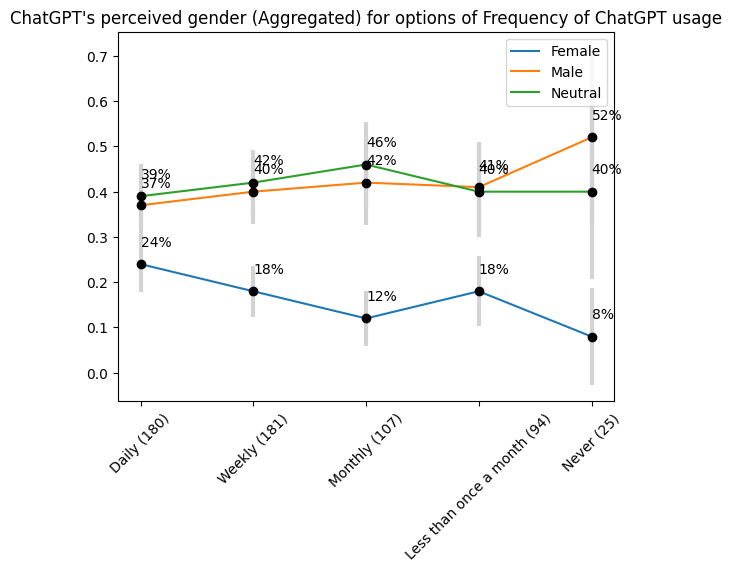

In [235]:
generate_curve_for_options(df_resps,"chat_agg_gender","chat_voiced",["No, only in a text box", 'Yes, with a male voice','Yes, with a female voice'])
generate_curve_for_options(df_resps,"chat_agg_gender","resp_gender",["Female","Male","Non-binary/Other"])
generate_curve_for_options(df_resps,"chat_agg_gender","resp_age",["<15","15-20","21-30","31-40","41-60",">60"])
generate_curve_for_options(df_resps,"chat_agg_gender","ai_perception",["Strongly Positive","Positive","Slightly Positive","Neutral","Slightly Negative","Negative","Strongly Negative"])
generate_curve_for_options(df_resps,"chat_agg_gender","chat_usage",['Daily', 'Weekly', 'Monthly', 'Less than once a month','Never'])

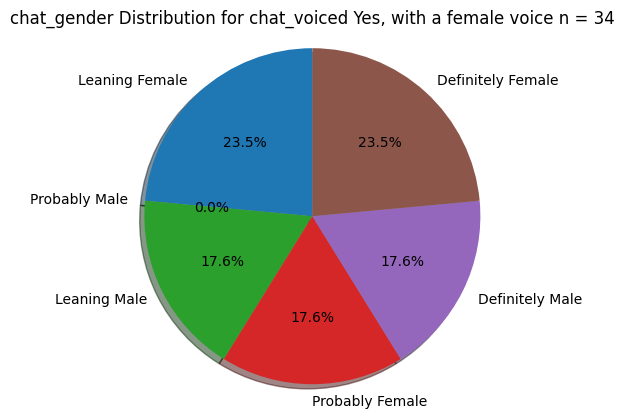

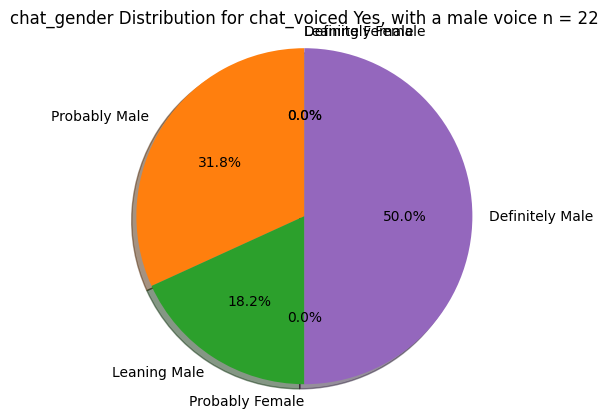

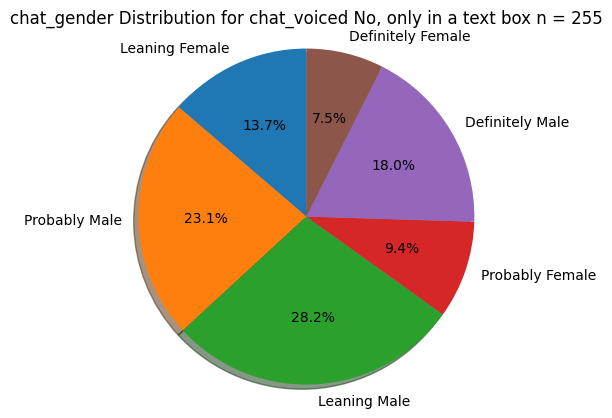

In [227]:
generate_pie_chart_for_option(df_without_neutrals,"chat_gender","chat_voiced","Yes, with a female voice")
generate_pie_chart_for_option(df_without_neutrals,"chat_gender","chat_voiced","Yes, with a male voice")
generate_pie_chart_for_option(df_without_neutrals,"chat_gender","chat_voiced","No, only in a text box")
# chat_voiced ['No, only in a text box' 'Yes, with a female voice' 'Yes, with a male voice']


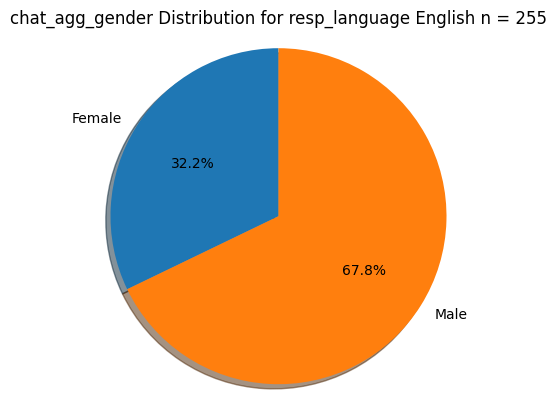

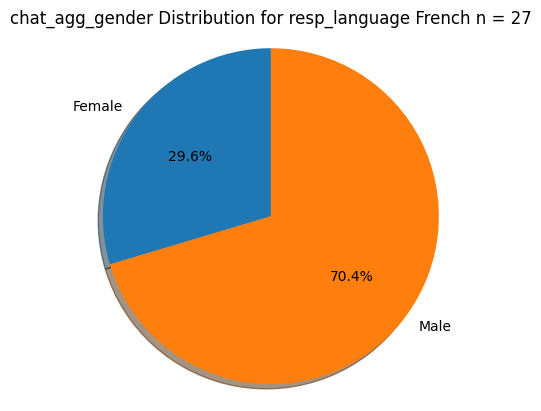

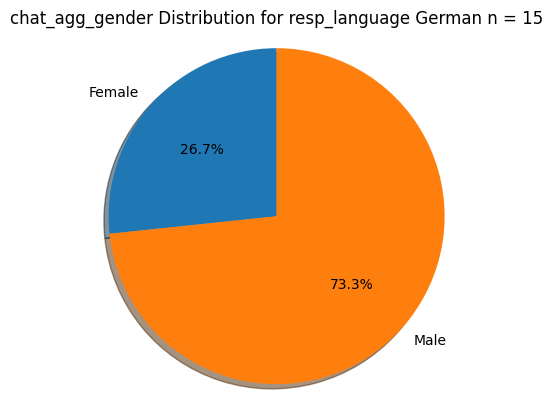

(255, 11)
(27, 11)
(15, 11)
(7, 11)
[[0.32 0.3  0.27 0.29]
 [0.68 0.7  0.73 0.71]]
[0.05725526467787336, 0.17285575232288658, 0.22467448453262334, 0.33615163245178503]
[0.05725526467787336, 0.17285575232288658, 0.22467448453262334, 0.3361516324517851]


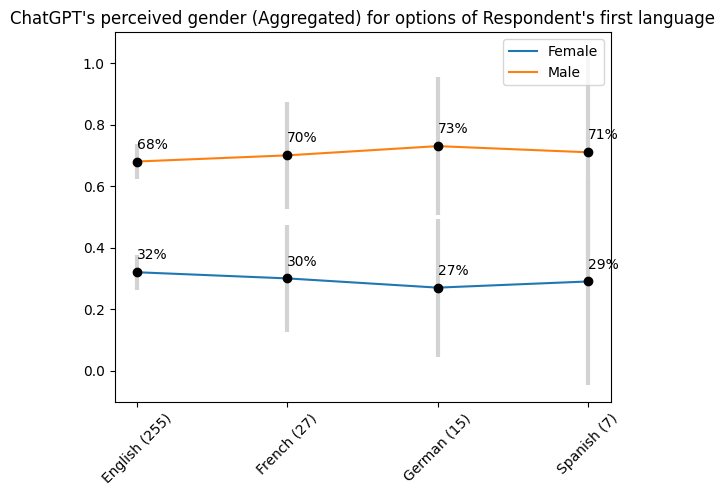

In [236]:
generate_pie_chart_for_option(df_without_neutrals,"chat_agg_gender","resp_language","English")
generate_pie_chart_for_option(df_without_neutrals,"chat_agg_gender","resp_language","French")
generate_pie_chart_for_option(df_without_neutrals,"chat_agg_gender","resp_language","German")
generate_curve_for_options(df_without_neutrals,"chat_agg_gender","resp_language",['English', 'French', 'German', 'Spanish'])

(109, 11)
(105, 11)
(58, 11)
(56, 11)
(15, 11)
[[0.01 0.   0.   0.02 0.07]
 [0.   0.   0.   0.   0.  ]
 [0.27 0.42 0.59 0.64 0.4 ]
 [0.35 0.25 0.24 0.09 0.4 ]
 [0.14 0.18 0.12 0.12 0.07]
 [0.21 0.13 0.05 0.07 0.07]
 [0.03 0.01 0.   0.04 0.  ]]
[0.018679292366220738, 0.0, 0.0, 0.03666824239038463, 0.12912220568128474]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.08334626346170249, 0.0944061014977316, 0.12657851863294317, 0.12571968819560445, 0.2479225685572009]
[0.08954338807876241, 0.08282511696339462, 0.1099143741972469, 0.07495558684981393, 0.2479225685572009]
[0.06514124667481137, 0.07348599866641263, 0.08363229866092611, 0.08511263125999571, 0.12912220568128474]
[0.0764655849913763, 0.06432691505116657, 0.05609044420428923, 0.0668270903152307, 0.12912220568128474]
[0.032025013159870955, 0.0190317629241224, 0.0, 0.051324847783505406, 0.0]


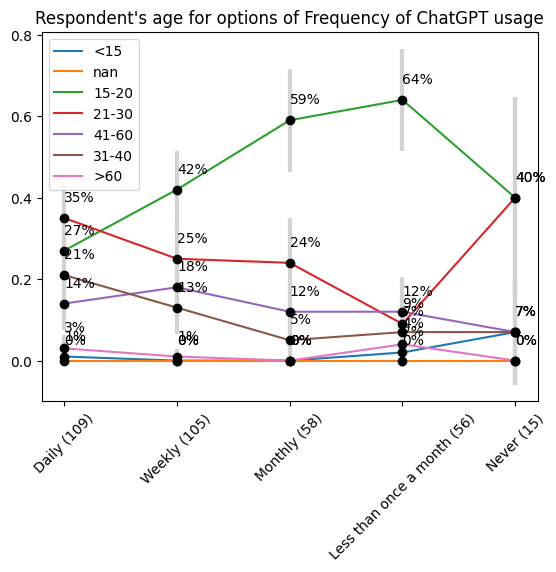

In [229]:
generate_curve_for_options(df_without_neutrals_has_age,"resp_age","chat_usage",['Daily', 'Weekly', 'Monthly', 'Less than once a month', 'Never'])

In [230]:
def checkSignficance(df, mainFeild, comparingOption, auxFeild, auxOp1, auxOp2, p=0.05): # check if the difference between auxOp1 and auxOp2 groups is significant for comparingOption
    auxOp1Count = df[(df[auxFeild] == auxOp1) & (df[mainFeild] == comparingOption)].shape[0]
    auxOp2Count = df[(df[auxFeild] == auxOp2) & (df[mainFeild] == comparingOption)].shape[0]
    auxOp1Total = df[df[auxFeild] == auxOp1].shape[0]
    auxOp2Total = df[df[auxFeild] == auxOp2].shape[0]
    ratio1 = auxOp1Count / auxOp1Total
    ratio2 = auxOp2Count / auxOp2Total
    diffP = chiTestDiff(auxOp1Count,auxOp1Total,auxOp2Count,auxOp2Total)
    sameP = zTestSame(auxOp1Count,auxOp1Total,auxOp2Count,auxOp2Total)
    diff = diffP < p
    same = sameP > 1-p
    print(f"{mainFeild}={comparingOption} for {auxFeild} {auxOp1} ({auxOp1Count}/{auxOp1Total}, {ratio1:.1%}) and {auxOp2} ({auxOp2Count}/{auxOp2Total}, {ratio2:.1%}) are statstically significantly differnt: {diff} ({diffP}), are same: {same} ({sameP})")
    return diff, same

checkSignficance(df_without_neutrals,"chat_agg_gender","Male","resp_gender","Male","Female")
checkSignficance(df_resps,"chat_agg_gender","Male","resp_gender","Male","Female")
checkSignficance(df_resps,"chat_agg_gender","Male","resp_gender_nbo","Yes","No")



chat_agg_gender=Male for resp_gender Male (126/192, 65.6%) and Female (98/137, 71.5%) are statstically significantly differnt: False (0.31092925337463356), are same: False (0.2571162069163502)
chat_agg_gender=Male for resp_gender Male (126/341, 37.0%) and Female (98/212, 46.2%) are statstically significantly differnt: True (0.03831754918553215), are same: False (0.03073215018049691)
chat_agg_gender=Male for resp_gender_nbo Yes (11/28, 39.3%) and No (224/560, 40.0%) are statstically significantly differnt: False (1.0), are same: False (0.9399736216009269)


(False, False)